# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

# Data Acquisition

In [2]:
# mapping of n1 n2 n3 values to category names
category_mapping = {
    "1": "Coarse genre",
    "1.1": "Company Business, Strategy, etc. (elaborate in Section 3 [Topics])",
    "1.2": "Purely Personal",
    "1.3": "Personal but in a professional context (e.g., it was good working with you)",
    "1.4": "Logistic Arrangements (meeting scheduling, technical support, etc)",
    "1.5": "Employment arrangements (job seeking, hiring, recommendations, etc)",
    "1.6": "Document editing/checking (collaboration)",
    "1.7": "Empty message (due to missing attachment)",
    "1.8": "Empty message",
    "2": "Included/forwarded information",
    "2.1": "Includes new text in addition to forwarded material",
    "2.2": "Forwarded email(s) including replies",
    "2.3": "Business letter(s) / document(s)",
    "2.4": "News article(s)",
    "2.5": "Government / academic report(s)",
    "2.6": "Government action(s) (such as results of a hearing, etc)",
    "2.7": "Press release(s)",
    "2.8": "Legal documents (complaints, lawsuits, advice)",
    "2.9": "Pointers to url(s)",
    "2.10": "Newsletters",
    "2.11": "Jokes, humor (related to business)",
    "2.12": "Jokes, humor (unrelated to business)",
    "2.13": "Attachment(s) (assumed missing)",
    "3": "Primary topics (if coarse genre 1.1 is selected)",
    "3.1": "Regulations and regulators (includes price caps)",
    "3.2": "Internal projects -- progress and strategy",
    "3.3": "Company image -- current",
    "3.4": "Company image -- changing / influencing",
    "3.5": "Political influence / contributions / contacts",
    "3.6": "California energy crisis / California politics",
    "3.7": "Internal company policy",
    "3.8": "Internal company operations",
    "3.9": "Alliances / partnerships",
    "3.10": "Legal advice",
    "3.11": "Talking points",
    "3.12": "Meeting minutes",
    "3.13": "Trip reports",
    "4": "Emotional tone (if not neutral)",
    "4.1": "Jubilation",
    "4.2": "Hope / anticipation",
    "4.3": "Humor",
    "4.4": "Camaraderie",
    "4.5": "Admiration",
    "4.6": "Gratitude",
    "4.7": "Friendship / affection",
    "4.8": "Sympathy / support",
    "4.9": "Sarcasm",
    "4.10": "Secrecy / confidentiality",
    "4.11": "Worry / anxiety",
    "4.12": "Concern",
    "4.13": "Competitiveness / aggressiveness",
    "4.14": "Triumph / gloating",
    "4.15": "Pride",
    "4.16": "Anger / agitation",
    "4.17": "Sadness / despair",
    "4.18": "Shame",
    "4.19": "Dislike / scorn"
}

#extract email text from all files
def decode_cats_file(file_content):
    decoded_info = []
    decoded_n2 = []
    lines = file_content.strip().split('\n')
    for line in lines:
        n1, n2, n3 = line.strip().split(',')
        category_n1 = category_mapping.get(n1, "Unknown Category")
        category_n2 = category_mapping.get(f"{n1}.{n2}", "Unknown Category")
        frequency = n3
        decoded_info.append(f"{n1},{n2},{n3}:\n"
                            f"n1 = {n1} ({category_n1})\n"
                            f"n2 = {n2} ({category_n2})\n"
                            f"n3 = {n3} (Frequency)")
        decoded_n2.append(category_n2)
    return decoded_info, decoded_n2

def extract_text_from_txt(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as txt_file:
            return txt_file.read()
    except Exception as e:
        print(f"Error reading text from {file_path}: {str(e)}")
        return ""

def process_files(root_folder):
    data = {"Folder": [], "File": [], "Decoded_Info": [], "Decoded_n2": [], "Text_Content": []}

    for root, _, files in os.walk(root_folder):
        for file in files:
            file_name, file_ext = os.path.splitext(file)
            file_path = os.path.join(root, file)

            if file_ext == ".cats":
                with open(file_path, "r", encoding="utf-8") as cats_file:
                    file_content = cats_file.read()
                    decoded_info, decoded_n2 = decode_cats_file(file_content)
            elif file_ext == ".txt": 
                text_content = extract_text_from_txt(file_path)
            else:
                continue

            data["Folder"].append(root)
            data["File"].append(file_name)  # Store without extension
            data["Decoded_Info"].append(decoded_info if file_ext == ".cats" else [])
            data["Decoded_n2"].append(decoded_n2 if file_ext == ".cats" else [])
            data["Text_Content"].append(text_content if file_ext == ".txt" else "")

    df = pd.DataFrame(data)
    return df

root_folder = "D:\V labs assignment"

df = process_files(root_folder)

# Extract the first element from each list in the Decoded_n2 column
df['First_Decoded_n2'] = df['Decoded_n2'].str[0]


df = df.drop(columns=["Decoded_Info", "Decoded_n2"])

# Group the DataFrame by the "File" column and aggregate the text content
df_merged = df.groupby("File").agg({
    "Text_Content": "\n".join,
    "First_Decoded_n2": "first"
}).reset_index()



In [3]:
df_merged.head()

,File,Text_Content,First_Decoded_n2
0,10425,\nMessage-ID: <197504.1075840201539.JavaMail.e...,"Company Business, Strategy, etc. (elaborate in..."
1,106296,\nMessage-ID: <11991339.1075842536086.JavaMail...,"Company Business, Strategy, etc. (elaborate in..."
2,106298,\nMessage-ID: <7106753.1075842536132.JavaMail....,"Company Business, Strategy, etc. (elaborate in..."
3,106588,\nMessage-ID: <21267718.1075863331587.JavaMail...,"Company Business, Strategy, etc. (elaborate in..."
4,106590,\nMessage-ID: <20866019.1075863331634.JavaMail...,"Company Business, Strategy, etc. (elaborate in..."


In [14]:
# Rename the "First_Decoded_n2" column to "Category"
final_df= df_merged .rename(columns={"First_Decoded_n2": "Category", "Text_Content": "Text"})

In [15]:
final_df.head()

,File,Text,Category
0,10425,\nMessage-ID: <197504.1075840201539.JavaMail.e...,"Company Business, Strategy, etc. (elaborate in..."
1,106296,\nMessage-ID: <11991339.1075842536086.JavaMail...,"Company Business, Strategy, etc. (elaborate in..."
2,106298,\nMessage-ID: <7106753.1075842536132.JavaMail....,"Company Business, Strategy, etc. (elaborate in..."
3,106588,\nMessage-ID: <21267718.1075863331587.JavaMail...,"Company Business, Strategy, etc. (elaborate in..."
4,106590,\nMessage-ID: <20866019.1075863331634.JavaMail...,"Company Business, Strategy, etc. (elaborate in..."


In [16]:
final_df = df_merged.drop(1702)

In [17]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702 entries, 0 to 1701
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   File      1702 non-null   object
 1   Text      1702 non-null   object
 2   Category  1702 non-null   object
dtypes: object(3)
memory usage: 40.0+ KB


In [18]:
# missing values
final_df.isnull().sum()

File        0
Text        0
Category    0
dtype: int64

In [19]:
final_df.duplicated().sum()

0

In [20]:
final_df.shape

(1702, 3)

# EDA

In [21]:
final_df.head()

,File,Text,Category
0,10425,\nMessage-ID: <197504.1075840201539.JavaMail.e...,"Company Business, Strategy, etc. (elaborate in..."
1,106296,\nMessage-ID: <11991339.1075842536086.JavaMail...,"Company Business, Strategy, etc. (elaborate in..."
2,106298,\nMessage-ID: <7106753.1075842536132.JavaMail....,"Company Business, Strategy, etc. (elaborate in..."
3,106588,\nMessage-ID: <21267718.1075863331587.JavaMail...,"Company Business, Strategy, etc. (elaborate in..."
4,106590,\nMessage-ID: <20866019.1075863331634.JavaMail...,"Company Business, Strategy, etc. (elaborate in..."


In [22]:
final_df['Category'].value_counts()

Company Business, Strategy, etc. (elaborate in Section 3 [Topics])             855
Logistic Arrangements (meeting scheduling, technical support, etc)             426
Document editing/checking (collaboration)                                      135
Personal but in a professional context (e.g., it was good working with you)    135
Employment arrangements (job seeking, hiring, recommendations, etc)             64
Purely Personal                                                                 48
Empty message (due to missing attachment)                                       21
Empty message                                                                   18
Name: Category, dtype: int64

In [23]:
#encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
final_df['Category1'] = encoder.fit_transform(final_df['Category'])
final_df.head()

,File,Text,Category,Category1
0,10425,\nMessage-ID: <197504.1075840201539.JavaMail.e...,"Company Business, Strategy, etc. (elaborate in...",0
1,106296,\nMessage-ID: <11991339.1075842536086.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0
2,106298,\nMessage-ID: <7106753.1075842536132.JavaMail....,"Company Business, Strategy, etc. (elaborate in...",0
3,106588,\nMessage-ID: <21267718.1075863331587.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0
4,106590,\nMessage-ID: <20866019.1075863331634.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0


In [24]:
final_df['Category1'].value_counts()

0    855
5    426
1    135
6    135
2     64
7     48
4     21
3     18
Name: Category1, dtype: int64

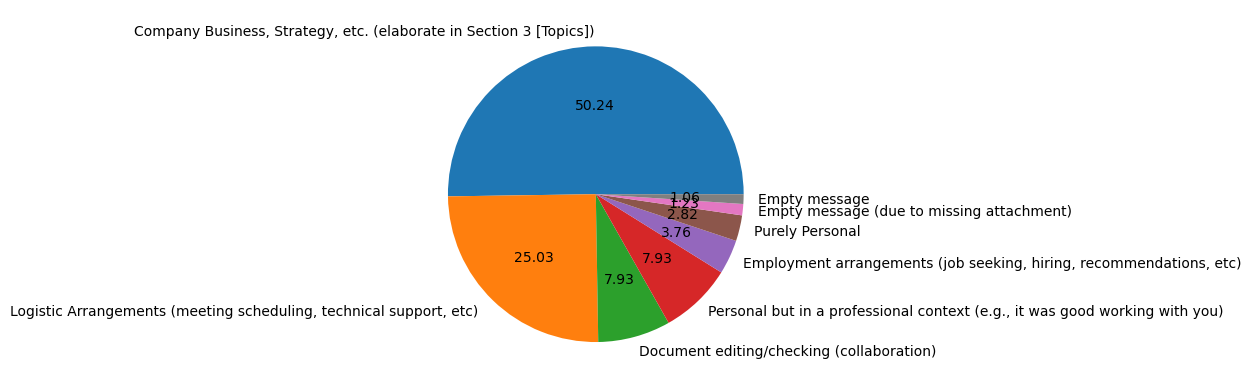

In [25]:
#data distribution
plt.pie(final_df['Category'].value_counts(), labels=['Company Business, Strategy, etc. (elaborate in Section 3 [Topics])','Logistic Arrangements (meeting scheduling, technical support, etc) ','Document editing/checking (collaboration) ','Personal but in a professional context (e.g., it was good working with you)','Employment arrangements (job seeking, hiring, recommendations, etc)','Purely Personal ','Empty message (due to missing attachment)','Empty message '],autopct="%0.2f")
plt.show()

In [26]:
final_df['num_characters'] = final_df['Text'].apply(len)

In [27]:
final_df.head()

,File,Text,Category,Category1,num_characters
0,10425,\nMessage-ID: <197504.1075840201539.JavaMail.e...,"Company Business, Strategy, etc. (elaborate in...",0,3481
1,106296,\nMessage-ID: <11991339.1075842536086.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,3755
2,106298,\nMessage-ID: <7106753.1075842536132.JavaMail....,"Company Business, Strategy, etc. (elaborate in...",0,5043
3,106588,\nMessage-ID: <21267718.1075863331587.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,5231
4,106590,\nMessage-ID: <20866019.1075863331634.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,4017


In [28]:
# num of words
final_df['num_words'] = final_df['Text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [29]:
final_df.head()

,File,Text,Category,Category1,num_characters,num_words
0,10425,\nMessage-ID: <197504.1075840201539.JavaMail.e...,"Company Business, Strategy, etc. (elaborate in...",0,3481,678
1,106296,\nMessage-ID: <11991339.1075842536086.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,3755,632
2,106298,\nMessage-ID: <7106753.1075842536132.JavaMail....,"Company Business, Strategy, etc. (elaborate in...",0,5043,920
3,106588,\nMessage-ID: <21267718.1075863331587.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,5231,986
4,106590,\nMessage-ID: <20866019.1075863331634.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,4017,710


In [30]:
final_df['num_sentences'] = final_df['Text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [31]:
final_df.head()

,File,Text,Category,Category1,num_characters,num_words,num_sentences
0,10425,\nMessage-ID: <197504.1075840201539.JavaMail.e...,"Company Business, Strategy, etc. (elaborate in...",0,3481,678,13
1,106296,\nMessage-ID: <11991339.1075842536086.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,3755,632,28
2,106298,\nMessage-ID: <7106753.1075842536132.JavaMail....,"Company Business, Strategy, etc. (elaborate in...",0,5043,920,38
3,106588,\nMessage-ID: <21267718.1075863331587.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,5231,986,38
4,106590,\nMessage-ID: <20866019.1075863331634.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,4017,710,28


In [32]:
final_df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,1702.000000,1702.000000,1702.000000
mean,14888.238543,2780.273208,79.793184
std,48561.692205,9211.871605,303.821290
min,789.000000,122.000000,1.000000
25%,2204.000000,408.000000,8.000000
50%,4096.000000,752.000000,17.000000
75%,7296.000000,1308.000000,36.000000
max,451567.000000,89446.000000,4223.000000


In [33]:
import seaborn as sns

<AxesSubplot:xlabel='num_characters', ylabel='Count'>

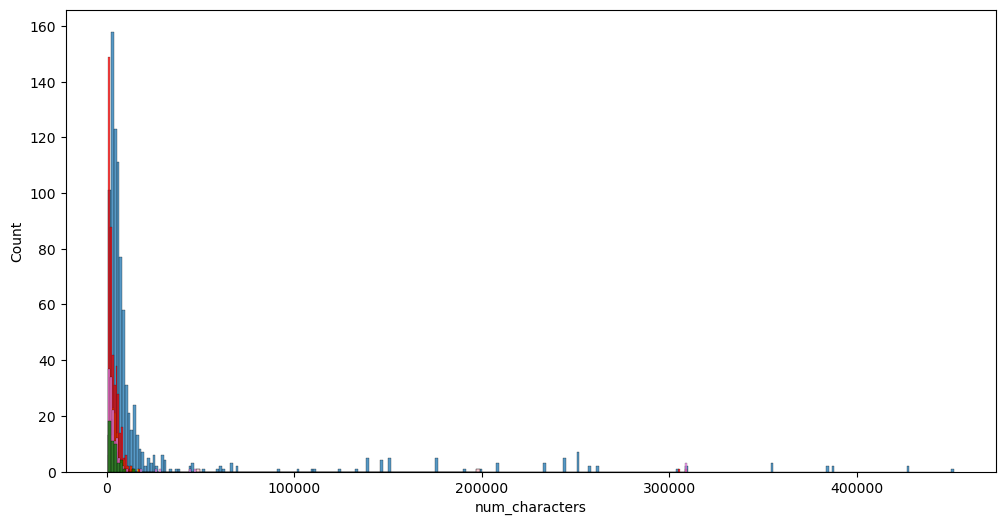

In [34]:
#plot of num_characters of email text
plt.figure(figsize=(12,6))
sns.histplot(final_df[final_df['Category1'] == 0]['num_characters'])
sns.histplot(final_df[final_df['Category1'] == 1]['num_characters'],color='yellow')
sns.histplot(final_df[final_df['Category1'] == 2]['num_characters'],color='blue')
sns.histplot(final_df[final_df['Category1'] == 3]['num_characters'],color='pink')
sns.histplot(final_df[final_df['Category1'] == 4]['num_characters'],color='orange')
sns.histplot(final_df[final_df['Category1'] == 5]['num_characters'],color='red')
sns.histplot(final_df[final_df['Category1'] == 6]['num_characters'],color='violet')
sns.histplot(final_df[final_df['Category1'] == 7]['num_characters'],color='green')

<AxesSubplot:xlabel='num_words', ylabel='Count'>

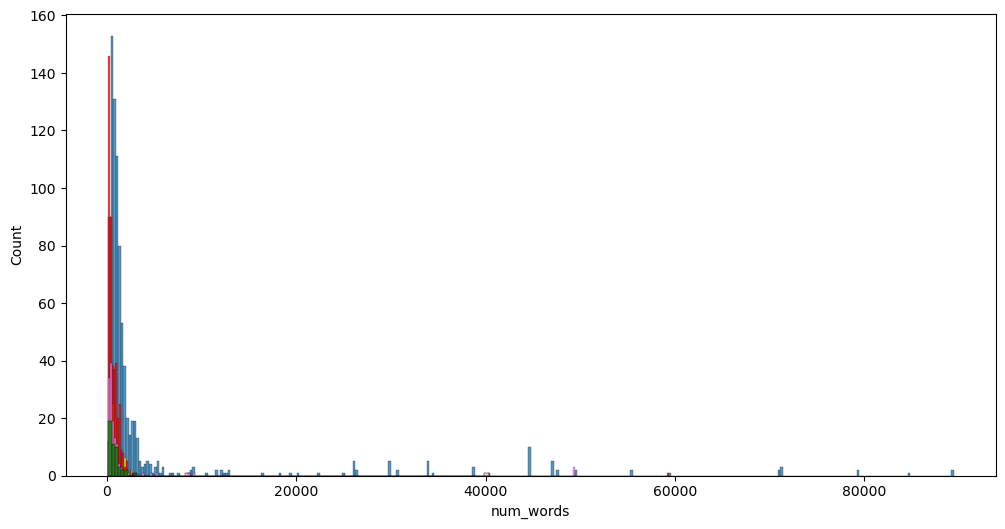

In [35]:
#plot of num_words of email text
plt.figure(figsize=(12,6))
sns.histplot(final_df[final_df['Category1'] == 0]['num_words'])
sns.histplot(final_df[final_df['Category1'] == 1]['num_words'],color='yellow')
sns.histplot(final_df[final_df['Category1'] == 2]['num_words'],color='blue')
sns.histplot(final_df[final_df['Category1'] == 3]['num_words'],color='pink')
sns.histplot(final_df[final_df['Category1'] == 4]['num_words'],color='orange')
sns.histplot(final_df[final_df['Category1'] == 5]['num_words'],color='red')
sns.histplot(final_df[final_df['Category1'] == 6]['num_words'],color='violet')
sns.histplot(final_df[final_df['Category1'] == 7]['num_words'],color='green')

# Data Cleaning and Preprocessing

In [36]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Kunal
[nltk_data]     Rane\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Kunal
[nltk_data]     Rane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
from nltk.corpus import stopwords
stopwords.words('english')


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [39]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [41]:
#lowering, removing stopwords,removing punctuation and stemming
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [42]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")


'gon na home soon want talk stuff anymor tonight k cri enough today'

In [43]:
final_df['transformed_text'] = final_df["Text"].apply(transform_text)

In [44]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [45]:
Company = wc.generate(final_df[final_df['Category1'] == 0]['transformed_text'].str.cat(sep=" "))

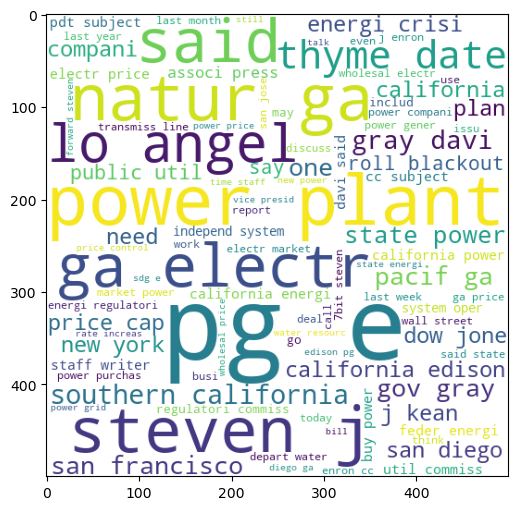

In [46]:
plt.figure(figsize=(15,6))
plt.imshow(Company)

In [47]:
Logistic = wc.generate(final_df[final_df['Category1'] == 5]['transformed_text'].str.cat(sep=" "))

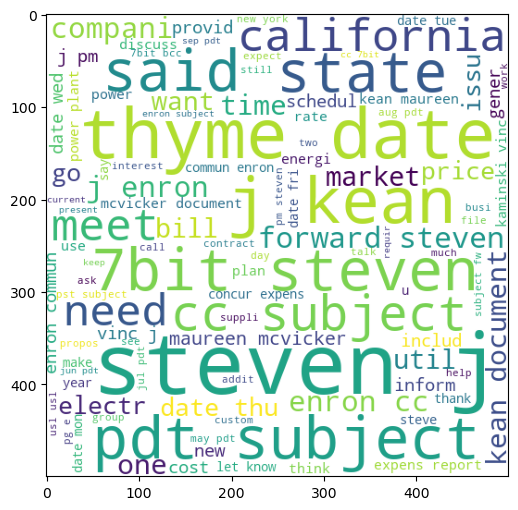

In [48]:
plt.figure(figsize=(15,6))
plt.imshow(Logistic)

# Train Test Split

In [49]:
from sklearn.model_selection import train_test_split
X = final_df.Text
y = final_df.Category1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [50]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1361,), (341,), (1361,), (341,))

# Applying Logistic Regression

In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])

lr.fit(X_train,y_train)
y_pred1 = lr.predict(X_test)

print(f"Accuracy is : {accuracy_score(y_pred1,y_test)}")
print(classification_report(y_pred1,y_test))

Accuracy is : 0.6598240469208211
              precision    recall  f1-score   support

           0       0.94      0.63      0.76       242
           1       0.03      0.50      0.05         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.73      0.75      0.74        81
           6       0.31      0.57      0.40        14
           7       0.33      1.00      0.50         2

    accuracy                           0.66       341
   macro avg       0.29      0.43      0.31       341
weighted avg       0.86      0.66      0.73       341



# Applying Naive Bayes Classifier

In [53]:
from sklearn.naive_bayes import MultinomialNB


naivebayes = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
naivebayes.fit(X_train, y_train)

y_pred = naivebayes.predict(X_test)

print(f'accuracy {accuracy_score(y_pred,y_test)}')
print(classification_report(y_pred,y_test))

accuracy 0.5219941348973607
              precision    recall  f1-score   support

           0       0.99      0.50      0.66       322
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.20      0.89      0.33        19
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.52       341
   macro avg       0.15      0.17      0.12       341
weighted avg       0.94      0.52      0.65       341



# Applying Xgboost Classifier

In [54]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
final_df['Category1'] = encoder.fit_transform(final_df['Category'])
final_df.head()

,File,Text,Category,Category1,num_characters,num_words,num_sentences,transformed_text
0,10425,\nMessage-ID: <197504.1075840201539.JavaMail.e...,"Company Business, Strategy, etc. (elaborate in...",0,3481,678,13,thyme date mon 18 oct 1999 pdt subject transla...
1,106296,\nMessage-ID: <11991339.1075842536086.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,3755,632,28,thyme date mon 5 mar 2001 pst subject tw ga sa...
2,106298,\nMessage-ID: <7106753.1075842536132.JavaMail....,"Company Business, Strategy, etc. (elaborate in...",0,5043,920,38,thyme date tue 6 mar 2001 pst subject tw ga sa...
3,106588,\nMessage-ID: <21267718.1075863331587.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,5231,986,38,thyme date tue 6 mar 2001 pst subject tw ga sa...
4,106590,\nMessage-ID: <20866019.1075863331634.JavaMail...,"Company Business, Strategy, etc. (elaborate in...",0,4017,710,28,thyme date mon 5 mar 2001 pst subject tw ga sa...


In [55]:
from sklearn.model_selection import train_test_split
X = final_df.Text
y = final_df.Category1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [56]:
from xgboost import XGBClassifier

xgboost = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)

print(f'accuracy {accuracy_score(y_pred,y_test)}')
print(classification_report(y_pred,y_test))

accuracy 0.6979472140762464
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       214
           1       0.47      0.74      0.58        23
           2       0.18      0.75      0.29         4
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.76      0.75      0.75        84
           6       0.19      0.62      0.29         8
           7       0.50      0.60      0.55         5

    accuracy                           0.70       341
   macro avg       0.38      0.52      0.40       341
weighted avg       0.80      0.70      0.73       341



# Applying Random forest classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier()),
              ])

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print(f'accuracy {accuracy_score(y_pred,y_test)}')
print(classification_report(y_pred,y_test))

accuracy 0.6334310850439883
              precision    recall  f1-score   support

           0       0.93      0.61      0.73       249
           1       0.08      0.50      0.14         6
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.66      0.74      0.70        74
           6       0.19      0.62      0.29         8
           7       0.33      0.67      0.44         3

    accuracy                           0.63       341
   macro avg       0.27      0.39      0.29       341
weighted avg       0.83      0.63      0.70       341



# Smote for balancing data

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


# Text preprocessing (TF-IDF vectorization)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X = tfidf_vectorizer.fit_transform(final_df['transformed_text'])

# Encoding target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(final_df['Category'])

In [59]:
from imblearn.combine import SMOTEENN
from sklearn.datasets import make_classification

# Create an instance of SMOTE-ENN resampler
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)

# Resample the dataset using SMOTE-ENN
X_resampled, y_resampled = smote_enn.fit_resample(X , y )

# Check the class distribution after resampling
unique, counts = np.unique(y_resampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution after SMOTE-ENN resampling:")
print(class_distribution)

Class distribution after SMOTE-ENN resampling:
{0: 170, 1: 815, 2: 849, 3: 851, 4: 853, 5: 583, 6: 824, 7: 851}


# Train Test Split after balancing data

In [60]:
from sklearn.model_selection import train_test_split
X = final_df.Text
y = final_df.Category
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state = 42)

In [61]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4636, 1000), (1160, 1000), (4636,), (1160,))

# Applying Logistic Regression after balancing data

In [62]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

lr = Pipeline([
               ('clf', LogisticRegression()),
              ])

lr.fit(X_train,y_train)
y_pred1 = lr.predict(X_test)

print(f"Accuracy is : {accuracy_score(y_pred1,y_test)}")
print(classification_report(y_pred1,y_test))

Accuracy is : 0.9568965517241379
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        43
           1       0.95      0.98      0.96       165
           2       0.98      0.97      0.98       174
           3       0.99      0.98      0.99       179
           4       0.98      0.93      0.96       176
           5       0.89      0.94      0.92       107
           6       0.91      0.93      0.92       162
           7       0.99      1.00      1.00       154

    accuracy                           0.96      1160
   macro avg       0.94      0.95      0.94      1160
weighted avg       0.96      0.96      0.96      1160



# Applying Naive Bayes Classifier after balancing data


In [64]:
from sklearn.naive_bayes import MultinomialNB


naivebayes = Pipeline([
               ('clf', MultinomialNB()),
              ])
naivebayes.fit(X_train, y_train)

y_pred = naivebayes.predict(X_test)

print(f'accuracy {accuracy_score(y_pred,y_test)}')
print(classification_report(y_pred,y_test))

accuracy 0.8663793103448276
              precision    recall  f1-score   support

           0       0.86      0.57      0.69        63
           1       0.90      0.88      0.89       174
           2       0.89      0.86      0.87       178
           3       0.88      0.99      0.93       157
           4       0.99      0.83      0.91       199
           5       0.73      0.91      0.81        91
           6       0.68      0.76      0.72       148
           7       0.94      0.97      0.96       150

    accuracy                           0.87      1160
   macro avg       0.86      0.85      0.85      1160
weighted avg       0.87      0.87      0.87      1160



# Applying Xgboost Classifier after balancing data

In [65]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
final_df['Category1'] = encoder.fit_transform(final_df['Category'])

In [66]:
from sklearn.model_selection import train_test_split
X = final_df.Text
y = final_df.Category1
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state = 42)

In [67]:
from xgboost import XGBClassifier

xgboost = Pipeline([
               ('clf', XGBClassifier()),
              ])
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)

print(f'accuracy {accuracy_score(y_pred,y_test)}')
print(classification_report(y_pred,y_test))

accuracy 0.9879310344827587
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        39
           1       0.97      0.99      0.98       166
           2       0.99      0.98      0.99       175
           3       1.00      0.99      1.00       177
           4       1.00      1.00      1.00       167
           5       0.97      0.97      0.97       113
           6       1.00      0.98      0.99       169
           7       0.99      1.00      1.00       154

    accuracy                           0.99      1160
   macro avg       0.98      0.99      0.98      1160
weighted avg       0.99      0.99      0.99      1160



# Applying Random forest classifier after balancing data

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = Pipeline([
               ('clf', RandomForestClassifier()),
              ])

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print(f'accuracy {accuracy_score(y_pred,y_test)}')
from sklearn.ensemble import RandomForestClassifier

rf_classifier = Pipeline([
               ('clf', RandomForestClassifier()),
              ])

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print(f'accuracy {accuracy_score(y_pred,y_test)}')
print(classification_report(y_pred,y_test))

accuracy 0.9905172413793103
accuracy 0.9913793103448276
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        36
           1       0.99      0.98      0.99       173
           2       1.00      0.99      0.99       174
           3       1.00      0.99      1.00       177
           4       1.00      1.00      1.00       167
           5       0.99      0.99      0.99       113
           6       0.99      0.99      0.99       165
           7       1.00      1.00      1.00       155

    accuracy                           0.99      1160
   macro avg       0.98      0.99      0.98      1160
weighted avg       0.99      0.99      0.99      1160

